In [1]:
import numpy as np
import joblib
import os, yaml, sys
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_relevant_output_layers, get_layer_out_shape
from pref_viewing.utils import plot_imgs
from alignment.utils import get_usual_transform, get_transform_to_show
from parallel.parallel_funcs import print_wise
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from torchvision.transforms import ToPILImage
from PIL import Image
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alignment.utils import get_usual_transform
from pref_viewing.utils import get_extreme_k
from datetime import datetime
import torch
from pref_viewing.utils import get_extreme_k, plot_imgs
from experiments.images_sampling import save_imgs_PCs, save_imgs_CCs
from experiments.utils import project_onto_PCs, project_onto_CCs, map_on_savenames, get_k_imgs
from dim_redu_anns.utils import get_relevant_output_layers
import pandas as pd

[Tiziano-Causin.local:60588] shmem: mmap: an error occurred while determining whether or not /var/folders/nw/yf48zdjj1m5012281wx_pzhc0000gn/T//ompi.Tiziano-Causin.501/jf.0/1370488832/sm_segment.Tiziano-Causin.501.51b00000.0 could be created.


In [2]:
#model_name2 = "vit_b_16"; target_layer2 = "conv_proj"
model_name2 = "alexnet"; target_layer2 = "features.0"
pooling = "PC_pool"
feats_path2 = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_features.pkl"
feats2 = joblib.load(feats_path2)

In [4]:
p = "/Users/tizianocausin/Library/CloudStorage/OneDrive-SISSA/data_repo/exp_set_res/silico/temp/imagenet_val_alexnet_features.0_pca_model_1000_PCs.pkl"

PCs = joblib.load(p)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model_cls = getattr(models, model_name2)
test_model = test_model_cls(pretrained=True).to(device).eval()
test_feature_extractor = create_feature_extractor(test_model, return_nodes=[target_layer2]).to(
    device
)

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ERROR! Session/line number was not unique in database. History logging moved to new session 41


In [13]:
imagenet_val_path = f"{paths['data_path']}/imagenet/val"
transform = get_usual_transform()
batch_size = 1
loader = DataLoader(
    datasets.ImageFolder(imagenet_val_path, transform=transform),
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
    pin_memory=True,
    timeout=500,
)

In [18]:
counter=0
all_feats = []
for inputs, _ in loader:
    counter += 1
    #print_wise(f"starting batch {counter}")
    if counter==100:
        break
    print(counter)
    with torch.no_grad():
        inputs = inputs.to(device)
        feats = test_feature_extractor(inputs)[target_layer2]
        feats = feats.view(feats.size(0), -1).cpu().numpy()
        feats = feats @ PCs.components_.T
        all_feats.append(feats)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [19]:
all_acts = np.concatenate(all_feats, axis=0)

In [20]:
loader_to_show = DataLoader(
    datasets.ImageFolder(imagenet_val_path, transform=get_transform_to_show()),
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
    pin_memory=True,
    timeout=500,
)

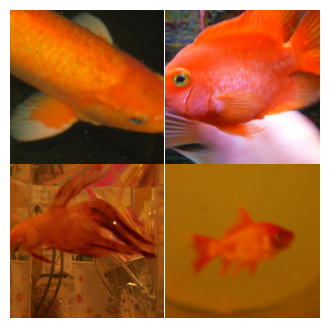

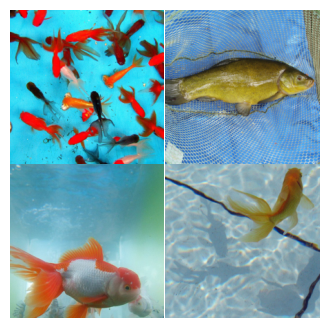

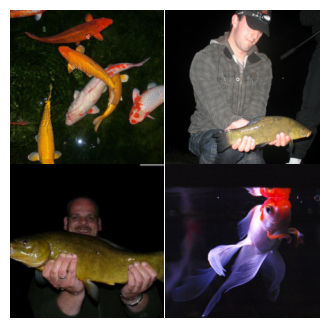

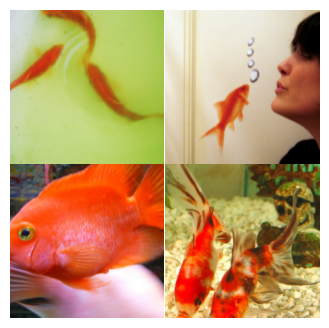

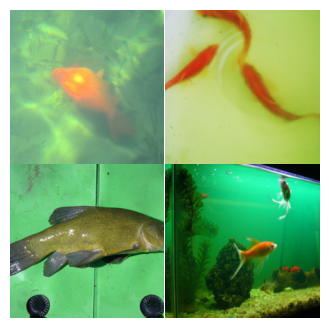

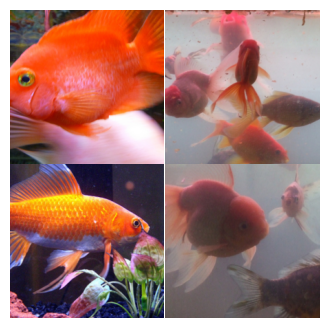

In [21]:

dataset_to_show = datasets.ImageFolder(f"{paths["data_path"]}/imagenet/val", transform=get_transform_to_show())
n_dims = 3
k = 4
extremes = ["top", "bottom"]
for d in range(n_dims):
    for extreme in extremes:
        img_list = []
        imgs_idx, imgs = get_k_imgs(all_acts, dataset_to_show, k, d, extreme)
        imgs = [img.permute(1,2,0) for img in imgs]
        img_list.append(imgs)
        plot_imgs(img_list, multi=True)

In [23]:
feats_path = "/Users/tizianocausin/Library/CloudStorage/OneDrive-SISSA/data_repo/exp_set_res/silico/temp/imagenet_val_alexnet_features.7_PC_pool_features.pkl"
feats = joblib.load(feats_path)

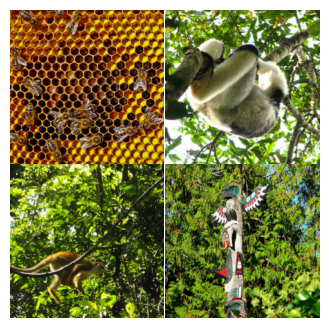

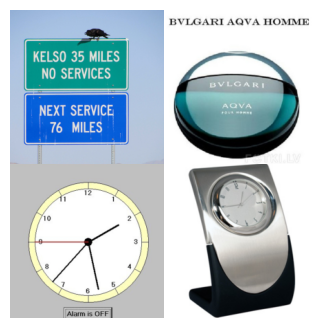

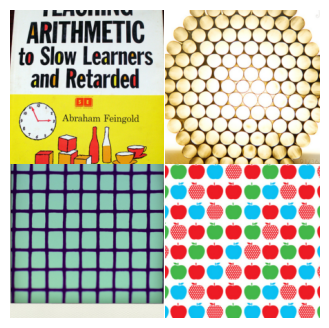

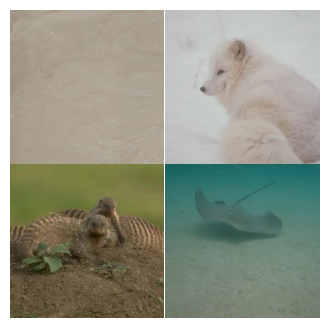

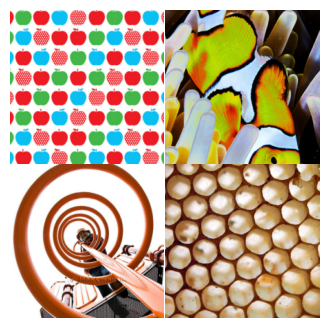

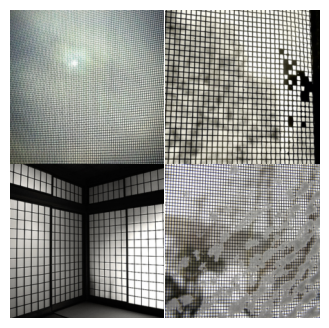

In [24]:
n_dims = 3
k = 4
extremes = ["top", "bottom"]
for d in range(n_dims):
    for extreme in extremes:
        img_list = []
        imgs_idx, imgs = get_k_imgs(feats, dataset_to_show, k, d, extreme)
        imgs = [img.permute(1,2,0) for img in imgs]
        img_list.append(imgs)
        plot_imgs(img_list, multi=True)

In [25]:
feats.shape

(50000, 1000)